In [1]:
import os

os.environ['DDE_BACKEND'] = 'tensorflow'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import numpy as np
import deepxde as dde

dde.config.set_default_float("float64")
dde.config.set_random_seed(42)
np.random.seed(42)

from deepxde.data import PDE
from deepxde.geometry import TimeDomain
from deepxde.icbc.initial_conditions import IC
from deepxde.icbc import PointSetBC
from deepxde.nn import FNN, PFNN
from deepxde.model import Model
from deepxde.callbacks import VariableValue, EarlyStopping
from deepxde.metrics import mean_squared_error
from scipy.integrate import solve_ivp
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd

from tensorflow.keras.optimizers.schedules import InverseTimeDecay

import sys
sys.path.append('../..')
from utils.custom_models import AdaptativeDataWeightModel

2025-12-04 13:58:24.878541: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



Set the default float type to float64


In [2]:
df = pd.read_csv("../../data/influenza_england_1978_school.csv")
df[:5]

,date,in_bed,convalescent
0,1978-01-22,3,0
1,1978-01-23,8,0
2,1978-01-24,26,0
3,1978-01-25,76,0
4,1978-01-26,225,9


In [3]:
df["date"]

0     1978-01-22
1     1978-01-23
2     1978-01-24
3     1978-01-25
4     1978-01-26
5     1978-01-27
6     1978-01-28
7     1978-01-29
8     1978-01-30
9     1978-01-31
10    1978-02-01
11    1978-02-02
12    1978-02-03
13    1978-02-04
Name: date, dtype: object

In [4]:

data_I = df["in_bed"].to_numpy()
data_I

array([  3,   8,  26,  76, 225, 298, 258, 233, 189, 128,  68,  29,  14,
         4])

In [5]:
t_0, t_f = 0, len(data_I)
gamma = 0.407
N = 763 # population size

In [6]:
I_min, I_max = data_I.min(axis=0), data_I.max(axis=0)
I_mean, I_std = data_I.mean(axis=0), data_I.std(axis=0)

# Z Scaling
def scale(data):
    return (data - I_mean) / I_std

def unscale(data):
    return data * I_std + I_mean

# # Min/Max
# def scale(data):
#     return (data - I_min) / (I_max - I_min)

# def unscale(data):
#     return I_min + (I_max - I_min) * data

In [7]:
data_I_scaled = scale(data_I)
I0 = data_I_scaled[0]
S0 = scale(N) - I0

In [8]:
S0, I0

(np.float64(7.318351700681466), np.float64(-1.043415369354679))

In [9]:
data_I_scaled

array([-1.04341537, -0.99526832, -0.82193894, -0.34046843,  1.09431368,
        1.79726062,  1.41208421,  1.17134896,  0.74765492,  0.1602609 ,
       -0.41750371, -0.79305071, -0.93749186, -1.03378596])

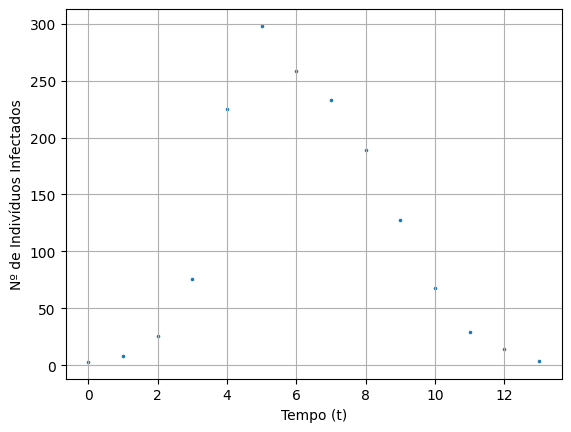

In [10]:
train_t = np.linspace(t_0, t_f - 1, t_f)
plt.scatter(train_t, data_I, s=2.5)
plt.xlabel("Tempo (t)")
plt.ylabel("Nº de Indivíduos Infectados")
plt.grid()
plt.savefig(f"../../images/data-english-board-school.png")
plt.show()

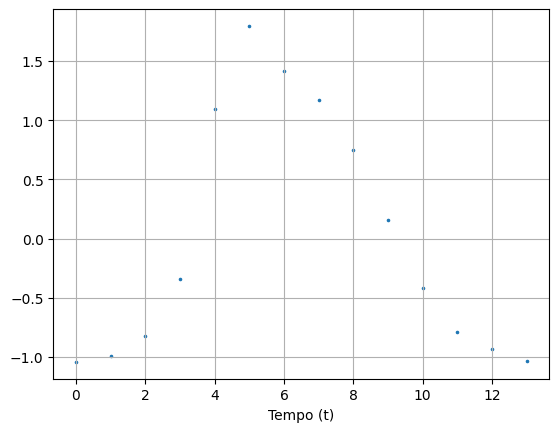

In [11]:
train_t = np.linspace(t_0, t_f - 1, t_f)
plt.scatter(train_t, data_I_scaled, s=2.5)
plt.xlabel("Tempo (t)")
plt.grid()
plt.show()

In [12]:
timeinterval = TimeDomain(t_0, t_f)

def sir_residual(t, y):

    S, I, beta = y[:,0:1], y[:,1:2], y[:,2:3]
    
    dS_dt = dde.gradients.jacobian(y, t, i=0)
    dI_dt = dde.gradients.jacobian(y, t, i=1)

    # S_unscaled = unscale(S)
    # N_unscaled = N / S_unscaled

    return [
        dS_dt + beta * (S * I),
        dI_dt - beta * (S * I) + gamma * I
    ]


# Tensorflow has an issue with lambdas...
def is_on_initial(_, on_initial): return on_initial

def S0_val(_): return S0
def I0_val(_): return I0

ic_S = IC(timeinterval, S0_val, is_on_initial, component=0)
ic_I = IC(timeinterval, I0_val, is_on_initial, component=1)

data_t = train_t.reshape(-1, 1)
data_I_bc = PointSetBC(data_t, data_I_scaled, component=1)

ics = [ic_S, ic_I]
data_conds = [data_I_bc]
conditions = ics + data_conds

data = PDE(
    timeinterval,
    sir_residual,
    conditions,
    num_domain=len(data_I)*2,
    num_boundary=2,
    num_test=len(data_I)//2,
    anchors=data_t
)

n_hidden_layers = 4
hidden_layer_size = 50
topology = [1] + [hidden_layer_size] * n_hidden_layers + [3]
activation = "tanh"
initializer = "Glorot uniform"
optimizer = "adam"
lr = 0.002

eq_w = 1
ic_w = 1
data_w = 10

n_equations = 2

# Com L2
# loss_weights = [eq_w] * n_equations + [ic1_w, ic2_w, ic3_w]  + [data_w] * len(data_conds) + [1]

# Sem L2
loss_weights = [eq_w] * n_equations + [ic_w] * len(ics)  + [data_w] * len(data_conds)

# net = FNN(
#     topology,
#     activation,
#     initializer,
#     # regularization=["L2", 1e-5],
#     # dropout_rate=0.1,
# )

net = PFNN(
    topology,
    activation,
    initializer,
    # regularization=["L2", 1e-5],
    # dropout_rate=0,
)

# model = AdaptativeDataWeightModel(data, net, n_physics=n_equations + len(ics), n_data=1)
model = Model(data, net)

model.compile(
    optimizer,
    lr,
    loss_weights=loss_weights
)


Compiling model...
'compile' took 0.007071 s



2025-12-04 13:58:32.095148: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1764867512.096050  320695 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2250 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [13]:
early_stopping = EarlyStopping(min_delta=1e-6, patience=5000)

adam_iterations = 100000

losshistory, train_state = model.train(
    iterations=adam_iterations, 
    display_every=100,
    callbacks=[
        early_stopping
    ]
)

model.compile(
    "L-BFGS", 
    loss_weights=loss_weights
)

dde.optimizers.set_LBFGS_options(
    # ftol=np.finfo(float).eps,
    maxiter=25000,
    ftol=1e-10,
    gtol=1e-12
)

losshistory, train_state = model.train(
    iterations=20000, 
    display_every=100
)

Training model...



2025-12-04 13:58:34.940737: I external/local_xla/xla/service/service.cc:163] XLA service 0x563045c7e540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-04 13:58:34.940818: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-12-04 13:58:34.955630: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-04 13:58:35.173238: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
I0000 00:00:1764867515.565755  320695 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                                            Test loss                                             Test metric
0         [1.30e-02, 1.14e-01, 5.36e+01, 1.09e+00, 1.78e+01]    [1.35e-02, 1.09e-01, 5.36e+01, 1.09e+00, 1.78e+01]    []  
100       [5.78e-03, 3.66e-03, 3.55e-07, 2.29e-01, 1.02e+01]    [3.69e-03, 9.15e-04, 3.55e-07, 2.29e-01, 1.02e+01]    []  
200       [2.85e-03, 1.93e-03, 7.51e-07, 2.03e-01, 1.03e+01]    [1.41e-03, 6.71e-04, 7.51e-07, 2.03e-01, 1.03e+01]    []  
300       [1.72e-03, 9.56e-04, 3.39e-07, 1.96e-01, 1.03e+01]    [8.43e-04, 3.44e-04, 3.39e-07, 1.96e-01, 1.03e+01]    []  
400       [1.13e-03, 5.73e-04, 1.64e-07, 1.93e-01, 1.03e+01]    [5.54e-04, 2.85e-04, 1.64e-07, 1.93e-01, 1.03e+01]    []  
500       [4.07e-03, 9.96e-04, 7.33e-06, 1.85e-01, 1.03e+01]    [1.27e-03, 5.97e-04, 7.33e-06, 1.85e-01, 1.03e+01]    []  
600       [5.15e-04, 2.58e-04, 5.82e-08, 1.91e-01, 1.03e+01]    [2.59e-04, 2.16e-04, 5.82e-08, 1.91e-01, 1.03e+01]    []  
700      

In [14]:
# model.save("../models/sir-nonoise")
# dde.saveplot(
#     losshistory, 
#     train_state, 
#     issave=True, 
#     isplot=False,
#     output_dir="../losses", 
#     loss_fname=f"loss-sir-nonoise",
#     train_fname=f"train-sir-nonoise",
#     test_fname=f"test-sir-nonoise")

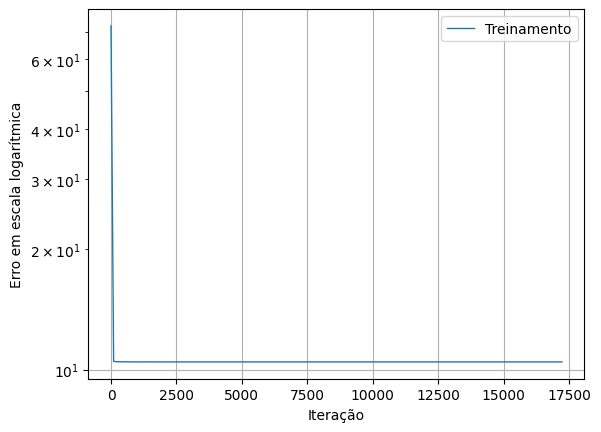

In [15]:
train = np.sum(losshistory.loss_train, axis=1)
plt.semilogy(losshistory.steps, train, "-", label="Treinamento", linewidth=1)
plt.xlabel("Iteração")
plt.ylabel("Erro em escala logarítmica")

plt.legend()
plt.grid()
plt.savefig(f"../../images/loss-english-board-school.png")
plt.show()

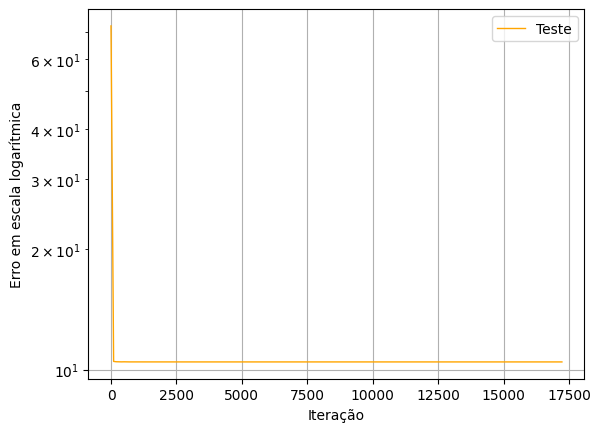

In [16]:
test = np.sum(losshistory.loss_test, axis=1)

plt.semilogy(losshistory.steps, test, "-", label="Teste", color="orange", linewidth=1)

plt.xlabel("Iteração")
plt.ylabel("Erro em escala logarítmica")

plt.legend()
plt.grid()
# plt.savefig(f"../images/sir-loss-nonoise.png")
plt.show()

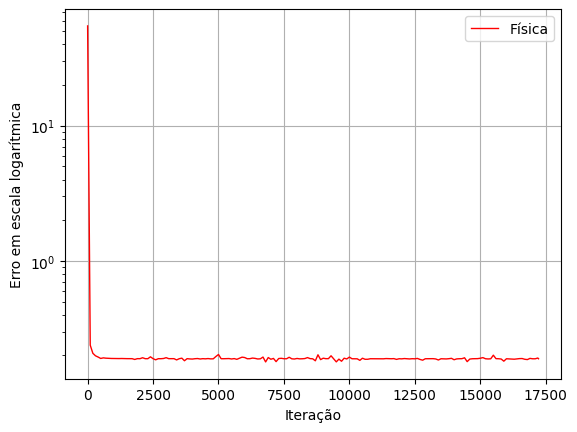

In [17]:
loss_train = np.array(losshistory.loss_train) 

train_phys = np.sum(loss_train[:,:len(ics) + n_equations], axis=1)
plt.semilogy(losshistory.steps, train_phys, "-", label="Física", color="red", linewidth=1)
plt.xlabel("Iteração")
plt.ylabel("Erro em escala logarítmica")
plt.legend()
plt.grid()
plt.show()

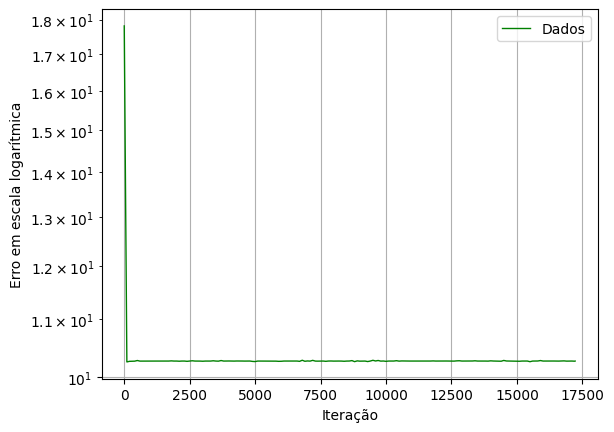

In [18]:
train_data = np.sum(loss_train[:,len(ics) + n_equations:], axis=1)
plt.semilogy(losshistory.steps, train_data, "-", label="Dados", color="green", linewidth=1)
plt.xlabel("Iteração")
plt.ylabel("Erro em escala logarítmica")
plt.legend()
plt.grid()
plt.show()

In [ ]:
if isinstance(model, AdaptativeDataWeightModel):
    plt.semilogy(np.arange(len(model.data_weight_hist)), model.data_weight_hist)
    plt.xlabel("Iteração")
    plt.ylabel("$\omega_{dados}$")
    plt.savefig("../../images/data-weight-english-board-school.png")
    plt.show()

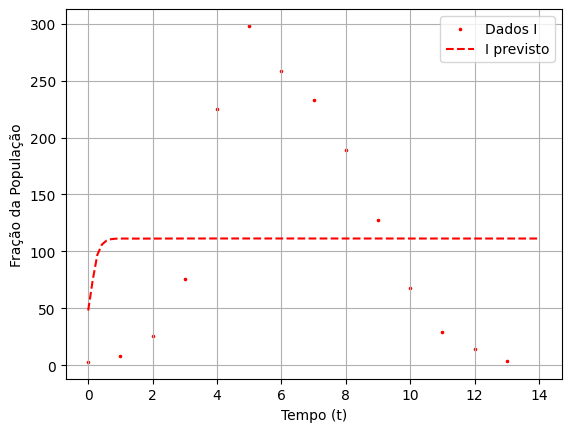

In [20]:
plt.rcParams['text.usetex'] = False
nop_test = 100

test_t = np.linspace(t_0, t_f, nop_test).reshape(-1, 1)
y_pred = model.predict(test_t)

I_pred = unscale(y_pred[:, 1])

plt.scatter(train_t, data_I, label="Dados I", color="red", s=2.5)
plt.plot(test_t, I_pred, label="I previsto", linestyle="--", color="red")

plt.xlabel("Tempo (t)")
plt.ylabel("Fração da População")

plt.legend()
plt.grid()
plt.savefig("../../images/predicted-invected-english-board-school.png")

plt.show()

[]

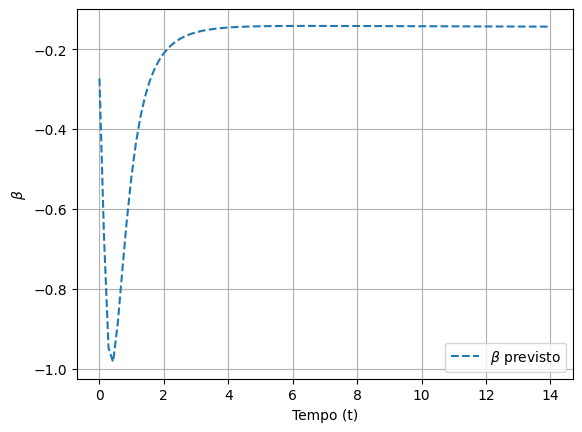

In [21]:
beta_pred = y_pred[:, 2]
plt.plot(test_t, beta_pred, label=r"$\beta$ previsto", linestyle="--")
plt.xlabel("Tempo (t)")
plt.ylabel(r"$\beta$")
plt.legend()
plt.grid()
plt.savefig("../../images/predicted-beta-english-board-school.png")
plt.plot()

[]

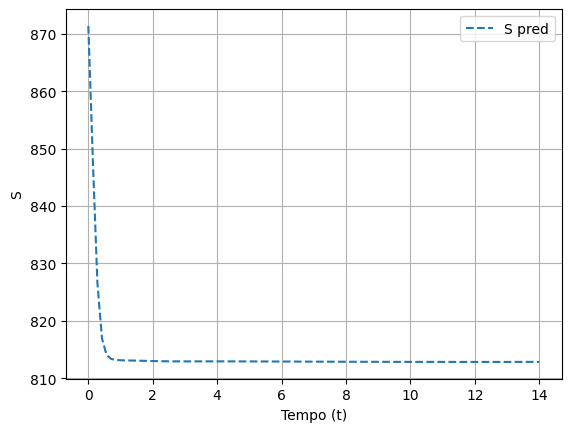

In [22]:
S_pred = unscale(y_pred[:, 0])
plt.plot(test_t, S_pred, label=r"S pred", linestyle="--")
plt.xlabel("Tempo (t)")
plt.ylabel(r"S")
plt.legend()
plt.grid()
plt.plot()

[]

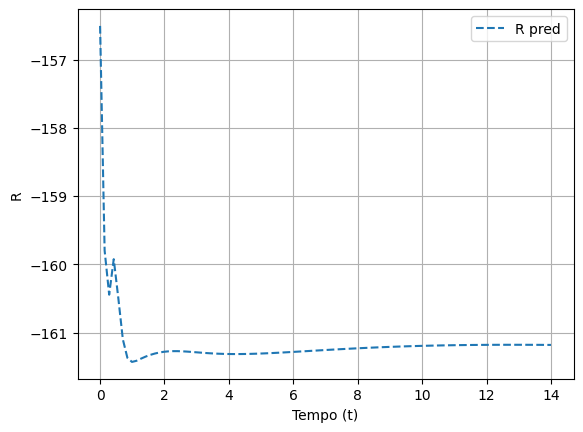

In [23]:
R_pred = N - S_pred - I_pred
plt.plot(test_t, R_pred, label=r"R pred", linestyle="--")
plt.xlabel("Tempo (t)")
plt.ylabel(r"R")
plt.legend()
plt.grid()
plt.plot()